In [3]:
import os, sys
cwd = os.getcwd()
# sys.path.insert(0, f"{cwd}/../")
sys.path.insert(0, "/home/emmanuel/code/rbig")

# RBIG Packages
from rbig.data import ToyData
from rbig.layers import RBIGBlock, RBIGKDEParams, RBIGHistParams, RBIGQuantileParams, RBIGPowerParams
from rbig.models import GaussianizationModel


from typing import Iterable, Optional, Dict, NamedTuple, Tuple, Union
import numpy as np

import numpy as np
from scipy import stats

# Plot Functions
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use(["seaborn-paper"])

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


1. Marginal Uni
2. Inverse CDF Gauss

1:
* Histogram
* KDE
* Mixture Dist

1 + 2:
* Quantiles
* ...

## Data

In [4]:
def plot_2d_joint(data, color='blue', title='Original Data'):
    
    fig  = plt.figure(figsize=(5, 5))

    g = sns.jointplot(x=data[:, 0], y=data[:, 1], kind='hex', color=color)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    
def plot_prob(data, probs, title='Probabilities'):
    
    fig, ax = plt.subplots()

    h = ax.scatter(data[:, 0], data[:, 1], s=1, c=probs, cmap='Reds')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    cbar = plt.colorbar(h, )
    ax.set_title(title)
    plt.show()

<Figure size 360x360 with 0 Axes>

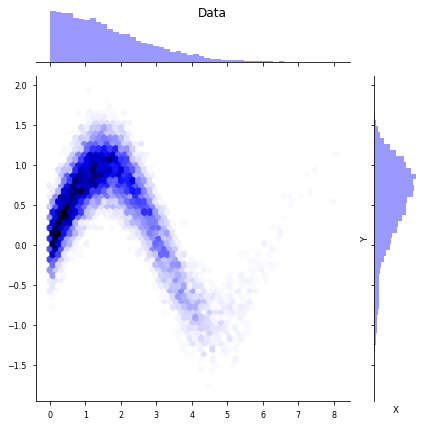

In [5]:
seed = 123
rng = np.random.RandomState(seed=seed)
dataset = 'rbig'
n_samples = 10_000
n_features = 2
noise = 0.25
random_state=1
clusters = 2


data = ToyData(
    dataset=dataset, 
    n_samples=n_samples, 
    n_features=n_features, 
    noise=noise, 
    random_state=random_state,
    clusters=clusters,
).generate_samples()

plot_2d_joint(data, title='Data')

### Function: RBIG Block

This block represents the sequence of RBIG Transforms:

1. Marginal Gaussianization
2. Rotation

### Psuedo-Code

1. Add Flow to iterable
2. Do Transformation (MG + Rot)
3. Check CallBack
    * Stopping Criteria - hard stop after layers
    * Total Correlation - Calculate marginal entropy
    * Negative Log-Likelihood - score
4. Check Convergence
    * If Done: repeat steps 1-3
    * Else: End training

In [19]:
rbig_block = RBIGHistParams(rotation='pca', nbins=1_000)
# rbig_block = RBIGKDEParams(rotation='pca', kde_method="exact")
# rbig_block = RBIGQuantileParams(rotation='pca', n_quantiles=1_000)
# rbig_block = RBIGPowerParams()

# rbig_block.rotation = 'pca'

rbig_block = rbig_block.fit_data(data)
rbig_block

MG Params: nbins=1000 alpha=1e-06 support_extension=10 
Rotation Params: rotation=pca random_state=123 kwargs={}

<Figure size 360x360 with 0 Axes>

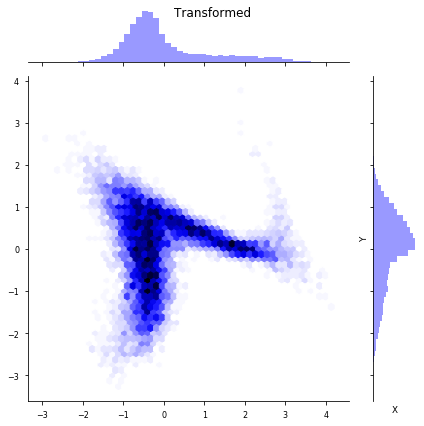

<Figure size 360x360 with 0 Axes>

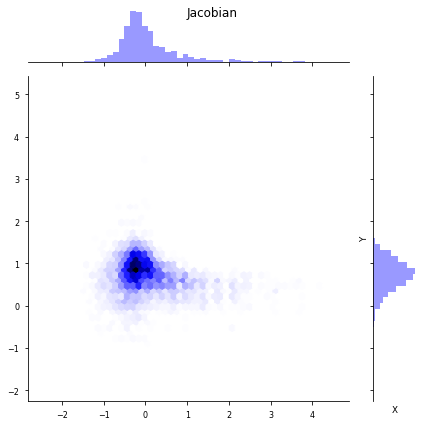

In [20]:
X_trans, dX_trans = rbig_block.transform(data, None, True)

plot_2d_joint(X_trans, title='Transformed')
plot_2d_joint(dX_trans, title='Jacobian')

<Figure size 360x360 with 0 Axes>

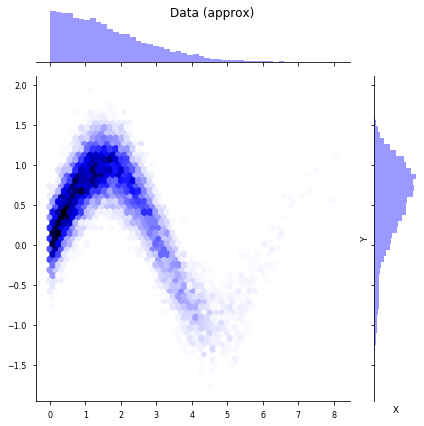

In [21]:
data_approx = rbig_block.inverse_transform(X_trans)
plot_2d_joint(data_approx, title='Data (approx)')

<Figure size 360x360 with 0 Axes>

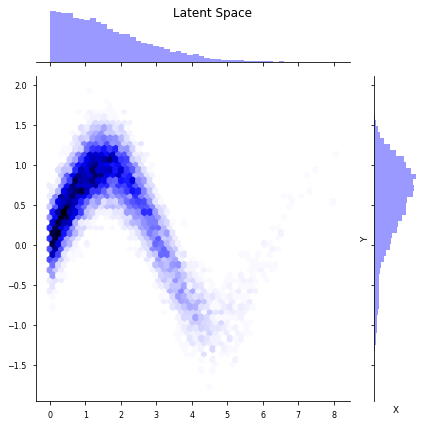

In [22]:
plot_2d_joint(data, title='Latent Space')



## 2. Multiple Layers

In [81]:
from rbig.losses import InformationLoss, MaxLayersLoss

# initialize params
rbig_block = RBIGHistParams(
    nbins=500, 
    alpha=1e-10,
    support_extension=5,
)
rbig_block = RBIGKDEParams(
    rotation='pca', 
    kde_method="exact", 
    n_quantiles=100,
    support_extension=5
)
# rbig_block = RBIGQuantileParams(rotation='pca', n_quantiles=500)
# rbig_block = RBIGPowerParams()
# initialize the RBIG Loss function
rbig_loss = InformationLoss(tol_layers=50, method='histogram')
# rbig_loss = MaxLayersLoss(n_layers=50)

rbig_model = GaussianizationModel(rbig_block, rbig_loss)

# fit model to data
rbig_model.fit(data)

GaussianizationModel(flow=RBIGKDEParams(kde_method='exact', bw_estimator='scott', support_extension=5, n_quantiles=100, rotation='pca', random_state=123, rot_kwargs={}),
                     loss=<rbig.losses.information.InformationLoss object at 0x7ff65e28a2e0>)

### Viz - Forward Transformation, Latent Space Z

<Figure size 360x360 with 0 Axes>

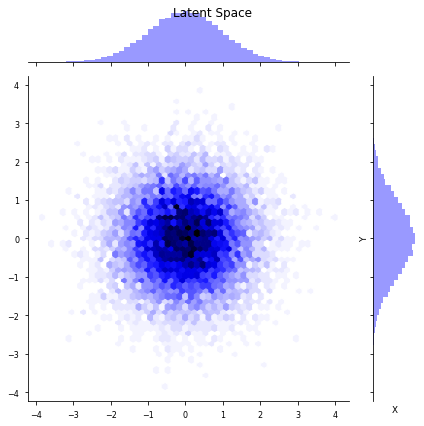

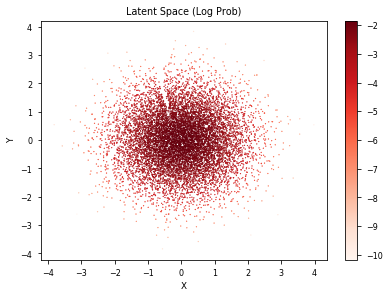

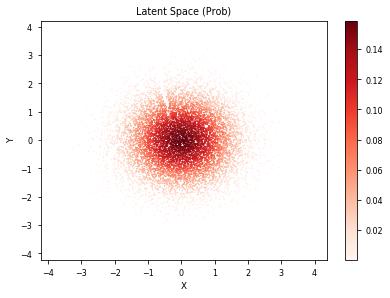

In [82]:
Z, X_slogdzet = rbig_model.transform(data)
plot_2d_joint(Z, title='Latent Space')

X_priorprob = stats.norm().logpdf(Z)


plot_prob(Z, X_priorprob.sum(axis=1), title='Latent Space (Log Prob)')
plot_prob(Z, np.exp(X_priorprob.sum(axis=1)), title='Latent Space (Prob)')

### Viz - Inverse Transformation, Data Space X

<Figure size 360x360 with 0 Axes>

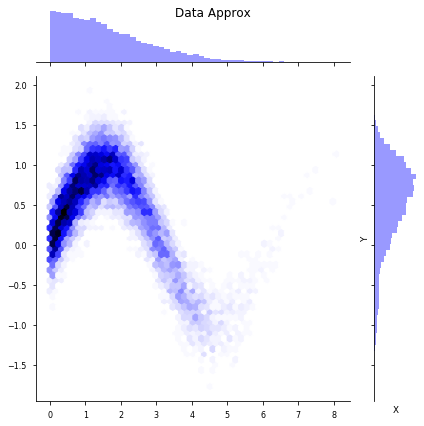

In [83]:
data_approx = rbig_model.inverse_transform(Z)
plot_2d_joint(data_approx, title='Data Approx')

### Viz - Sampling, Data Space X

<Figure size 360x360 with 0 Axes>

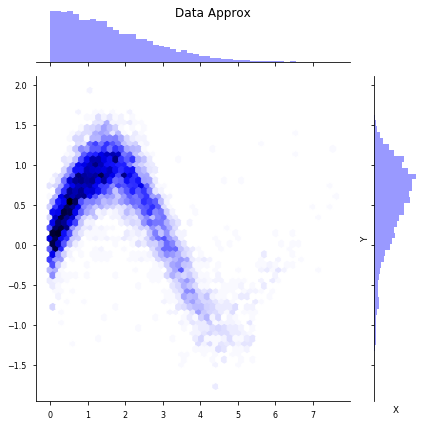

In [84]:
data_approx = rbig_model.sample(10_000)
plot_2d_joint(data_approx, title='Data Approx')

### Viz - Probabilities, Data Space X

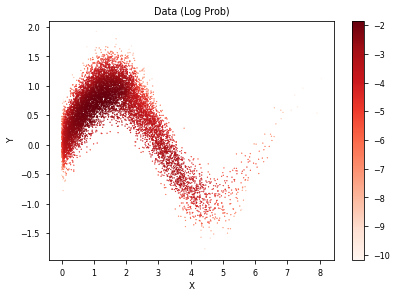

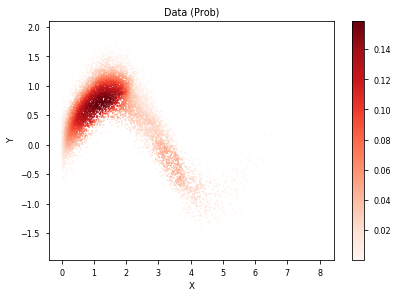

In [85]:
X_prob = rbig_model.score_samples(data)

plot_prob(data, X_prob, title='Data (Log Prob)')
plot_prob(data, np.exp(X_prob), title='Data (Prob)')

In [86]:
X_nll = rbig_model.score(data, None)
print('Negative Log-Likelihood:',X_nll)
print('Negative Likelihood:',np.exp(X_nll))

Negative Log-Likelihood: -3.102374283184466
Negative Likelihood: 0.04494236970555514


In [87]:
X_nll = rbig_model.score(data, None)
print('Negative Log-Likelihood:',X_nll)
print('Negative Likelihood:',np.exp(X_nll))

Negative Log-Likelihood: -3.102374283184466
Negative Likelihood: 0.04494236970555514


### Viz - Negative Log-Likelihood

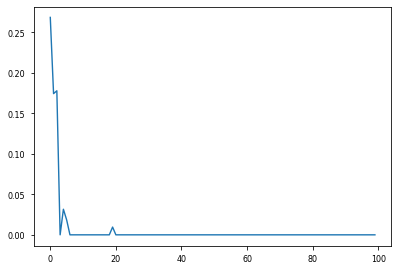

In [88]:
plt.plot(rbig_model.losses_)